In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Create a SparkSession
spark = SparkSession.builder.appName("Testing PySpark Example").getOrCreate()
# Set default session time zone to CET
spark.conf.set("spark.sql.session.timeZone", "Europe/Amsterdam")


In [ ]:
from datetime import datetime, date
from decimal import Decimal
from pyspark.sql import Row

# fin_data with TrxId before RecordDate
schema = "TrxDT Timestamp, CreditDebit String, AmountEuro Decimal(12,7), AccountName String, TrxId Integer, RecordDate Date"
fin_data = [
        Row(TrxDT=datetime(2025,3,6,20,45,19), CreditDebit="Credit", AmountEuro=Decimal(700.30),  AccountName="Madame Zsa Zsa", TrxId=1,  RecordDate=date(2025,3,6)),
        Row(TrxDT=datetime(2025,3,6,12,22,1),  CreditDebit="Debit",  AmountEuro=Decimal(200.00),  AccountName="Madame Zsa Zsa", TrxId=2,  RecordDate=date(2025,3,6)),
        Row(TrxDT=datetime(2025,3,6,20,59,0),  CreditDebit="Debit",  AmountEuro=Decimal(1110.20), AccountName="Madame Zsa Zsa", TrxId=3,  RecordDate=date(2025,3,6)),
        Row(TrxDT=datetime(2025,3,6,23,50,0),  CreditDebit="Credit", AmountEuro=Decimal(50.00),   AccountName="Madame Zsa Zsa", TrxId=4,  RecordDate=date(2025,3,7)),
        Row(TrxDT=datetime(2025,3,6,8,0,0),    CreditDebit="Credit", AmountEuro=Decimal(1500.00), AccountName="Mr. X",         TrxId=5 ,  RecordDate=date(2025,3,7)),
        Row(TrxDT=datetime(2025,3,7,14,45,0),  CreditDebit="Debit",  AmountEuro=Decimal(300.25),  AccountName="Mr. X",         TrxId=6 ,  RecordDate=date(2025,3,7)),
        Row(TrxDT=datetime(2025,3,10,9,0,0),   CreditDebit="Credit", AmountEuro=Decimal(99.99),   AccountName="Mr. X",         TrxId=7 ,  RecordDate=date(2025,3,8)),
]

df_a = spark.createDataFrame(fin_data, schema=schema)

# sepa_data with TrxId and RecordDate
sepa_schema = "TrxId Integer, CountryCode String, RecordDate Date"
sepa_data = [
        Row(TrxId=1,  CountryCode="NL", RecordDate=date(2025,3,5)),
        Row(TrxId=2,  CountryCode="NL", RecordDate=date(2025,3,4)),
        Row(TrxId=3,  CountryCode="NL", RecordDate=date(2025,3,6)),
        Row(TrxId=4,  CountryCode="UK", RecordDate=date(2025,3,7)),
        Row(TrxId=5,  CountryCode="NL", RecordDate=date(2025,3,12)),
        Row(TrxId=6,  CountryCode="NL", RecordDate=date(2025,3,18)),
        Row(TrxId=7,  CountryCode="DE", RecordDate=date(2025,3,6)),
]

df_b = spark.createDataFrame(sepa_data, schema=sepa_schema)

df_a.show(truncate=False)
df_b.show(truncate=False)


+-------------------+-----------+------------+--------------+-----+----------+
|TrxDT              |CreditDebit|AmountEuro  |AccountName   |TrxId|RecordDate|
+-------------------+-----------+------------+--------------+-----+----------+
|2025-03-06 20:45:19|Credit     |700.3000000 |Madame Zsa Zsa|1    |2025-03-06|
|2025-03-06 12:22:01|Debit      |200.0000000 |Madame Zsa Zsa|2    |2025-03-06|
|2025-03-06 20:59:00|Debit      |1110.2000000|Madame Zsa Zsa|3    |2025-03-06|
|2025-03-06 23:50:00|Credit     |50.0000000  |Madame Zsa Zsa|4    |2025-03-07|
|2025-03-06 08:00:00|Credit     |1500.0000000|Mr. X         |5    |2025-03-07|
|2025-03-07 14:45:00|Debit      |300.2500000 |Mr. X         |6    |2025-03-07|
|2025-03-10 09:00:00|Credit     |99.9900000  |Mr. X         |7    |2025-03-08|
+-------------------+-----------+------------+--------------+-----+----------+

+-----+-----------+----------+
|TrxId|CountryCode|RecordDate|
+-----+-----------+----------+
|1    |NL         |2025-03-05|
|2    

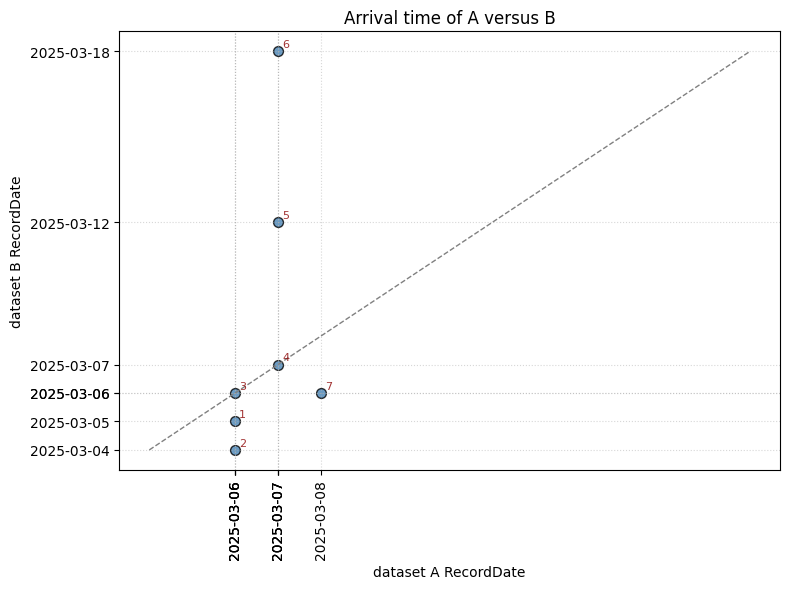

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.functions import col

# Join on TrxId and convert to pandas
joined_pdf = (
    df_a.alias("a")
      .join(df_b.alias("s"), on="TrxId", how="inner")
      .select(
          col("a.RecordDate").alias("fin_record_date"),
          col("s.RecordDate").alias("sepa_record_date"),
          col("a.TrxId")
      )
      .toPandas()
)

# Convert to pandas datetime
joined_pdf["fin_record_date"] = pd.to_datetime(joined_pdf["fin_record_date"]) 
joined_pdf["sepa_record_date"] = pd.to_datetime(joined_pdf["sepa_record_date"]) 

plt.figure(figsize=(8, 6))

# ✅ Add scatter plot (dots)
plt.scatter(
    joined_pdf["fin_record_date"], 
    joined_pdf["sepa_record_date"], 
    s=50,             # dot size
    color="steelblue", 
    alpha=0.8, 
    edgecolor="black"
)

# ✅ Diagonal reference line (y = x)
min_d = min(joined_pdf["fin_record_date"].min(), joined_pdf["sepa_record_date"].min())
max_d = max(joined_pdf["fin_record_date"].max(), joined_pdf["sepa_record_date"].max())
plt.plot([min_d, max_d], [min_d, max_d], linestyle="--", color="gray", linewidth=1)

# ✅ Annotate each point with TrxId
for _, row in joined_pdf.iterrows():
    plt.annotate(
        row["TrxId"],
        (row["fin_record_date"], row["sepa_record_date"]),
        xytext=(3, 3),
        textcoords="offset points",
        fontsize=8,
        color="darkred",
        alpha=0.8
    )

# ✅ Axis and style
plt.xlabel("dataset A")
plt.ylabel("dataset B")
plt.title("Arrival time of A versus B")
plt.grid(True, linestyle=":", alpha=0.5)
plt.xticks(rotation=90)
plt.tight_layout()
plt.xticks(joined_pdf["fin_record_date"])
plt.yticks(joined_pdf["sepa_record_date"])

plt.show()


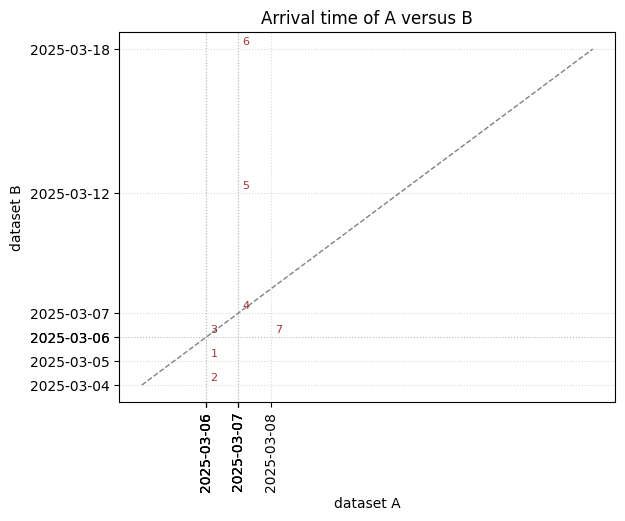

In [ ]:
# Join on TrxId and visualize RecordDate vs RecordDate
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

joined_pdf = (
    df_a.alias("a")
      .join(df_b.alias("s"), on="TrxId", how="inner")
      .select(col("a.RecordDate").alias("fin_record_date"),
              col("s.RecordDate").alias("sepa_record_date"),
              col("a.TrxId")
              )
      .toPandas()
)

# Ensure pandas datetime for plotting (dates work too, but this is explicit)
joined_pdf["fin_record_date"] = pd.to_datetime(joined_pdf["fin_record_date"]) 
joined_pdf["sepa_record_date"] = pd.to_datetime(joined_pdf["sepa_record_date"]) 

# Diagonal reference line (y = x) covering min..max of both axes
min_d = min(joined_pdf["fin_record_date"].min(), joined_pdf["sepa_record_date"].min())
max_d = max(joined_pdf["fin_record_date"].max(), joined_pdf["sepa_record_date"].max())
plt.plot([min_d, max_d], [min_d, max_d], linestyle="--", color="gray", linewidth=1)

plt.xlabel("dataset A")
plt.ylabel("dataset B")
plt.title("Arrival time of A versus B")
plt.grid(True, linestyle=":", alpha=0.5)
plt.xticks(rotation=90)
plt.xticks(joined_pdf["fin_record_date"])
plt.yticks(joined_pdf["sepa_record_date"])

# Annotate each point with its TrxId
for _, row in joined_pdf.iterrows():
    plt.annotate(
        row["TrxId"],
        (row["fin_record_date"], row["sepa_record_date"]),
        xytext=(3, 3),  # offset in points from the data point
        textcoords="offset points",
        fontsize=8,
        color="darkred",
        alpha=0.8
    )


plt.show()
